In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point

# POLLUTION DATA ============================================================
folder_path = 'data_air_5'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
dfs = []

csv_files = ['Slovenia_AirQuality_1kmGrid_2024_withBounds.csv']

for file in csv_files:
    if 'AirQuality' in file:
        file_path = os.path.join(folder_path, file)  
        df = pd.read_csv(file_path, low_memory=False)  
        #dfs.append(df)

#df_pollution = pd.concat(dfs, ignore_index=True)
df_pollution = df
df_pollution['lon'] = df_pollution['lon'].astype('float')
df_pollution['lat'] = df_pollution['lat'].astype('float')

for pollution_value in df_pollution.columns:
    if pollution_value not in ['grid_id']:
        df_pollution[pollution_value] = df_pollution[pollution_value].astype('float')

print(df_pollution.head())


    grid_id        lon        lat     sw_lon     sw_lat     ne_lon     ne_lat  \
0  475,5029  14.686858  45.418591  14.680442  45.414073  14.693273  45.423109   
1  476,5029  14.699639  45.418626  14.693224  45.414108  14.706053  45.423143   
2  477,5029  14.712420  45.418659  14.706006  45.414142  14.718833  45.423175   
3  478,5029  14.725202  45.418690  14.718789  45.414174  14.731613  45.423206   
4  479,5029  14.737983  45.418720  14.731571  45.414205  14.744394  45.423235   

     year   no2_ppb        co_ppb   so2_ppb    o3_ppb      ch4_ppb  
0  2024.0  0.000068  3.025123e+07  0.000254  0.151969  1863.686556  
1  2024.0  0.000068  3.035399e+07  0.000211  0.152038  1863.686554  
2  2024.0  0.000069  3.043667e+07  0.000199  0.152069  1863.686518  
3  2024.0  0.000069  3.055065e+07  0.000216  0.152120  1863.686504  
4  2024.0  0.000069  3.058887e+07  0.000243  0.152156  1863.686485  


In [2]:
# ========= SLOVENIA SHAPE ===================================================================================================

slovenia_shapefile = os.path.join('Slovenia_shapefile', 'si_1km.shp')    
slovenia_shape = gpd.read_file(slovenia_shapefile)
slovenia_shape = slovenia_shape.to_crs("EPSG:4326")

df_pollution['geometry'] = df_pollution.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf_pollution = gpd.GeoDataFrame(df_pollution, geometry='geometry', crs="EPSG:4326")

gdf_pollution = gdf_pollution[gdf_pollution.geometry.within(slovenia_shape.unary_union)]
gdf_pollution.to_csv('pollution_SLO.csv', index=False)

show_plot = False

if show_plot:
    plt.figure(figsize=(8, 6))
    slovenia_shape.boundary.plot(color='black', linewidth=0.5)
    plt.scatter(gdf_pollution['lon'], gdf_pollution['lat'], c='red', alpha=0.5, label='Pollution Points')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pollution Points in Slovenia')
    plt.legend()
    plt.grid(True)
    plt.show()

C:\Users\Katalea\AppData\Local\Temp\ipykernel_4340\944148377.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_pollution = gdf_pollution[gdf_pollution.geometry.within(slovenia_shape.unary_union)]


    grid_id        lon        lat     sw_lon     sw_lat     ne_lon     ne_lat  \
0  475,5029  14.686858  45.418591  14.680442  45.414073  14.693273  45.423109   
1  476,5029  14.699639  45.418626  14.693224  45.414108  14.706053  45.423143   
2  477,5029  14.712420  45.418659  14.706006  45.414142  14.718833  45.423175   
3  478,5029  14.725202  45.418690  14.718789  45.414174  14.731613  45.423206   
4  479,5029  14.737983  45.418720  14.731571  45.414205  14.744394  45.423235   

     year   no2_ppb        co_ppb   so2_ppb    o3_ppb      ch4_ppb  \
0  2024.0  0.000068  3.025123e+07  0.000254  0.151969  1863.686556   
1  2024.0  0.000068  3.035399e+07  0.000211  0.152038  1863.686554   
2  2024.0  0.000069  3.043667e+07  0.000199  0.152069  1863.686518   
3  2024.0  0.000069  3.055065e+07  0.000216  0.152120  1863.686504   
4  2024.0  0.000069  3.058887e+07  0.000243  0.152156  1863.686485   

                                            geometry square_id  
0  POLYGON ((474988.523 305

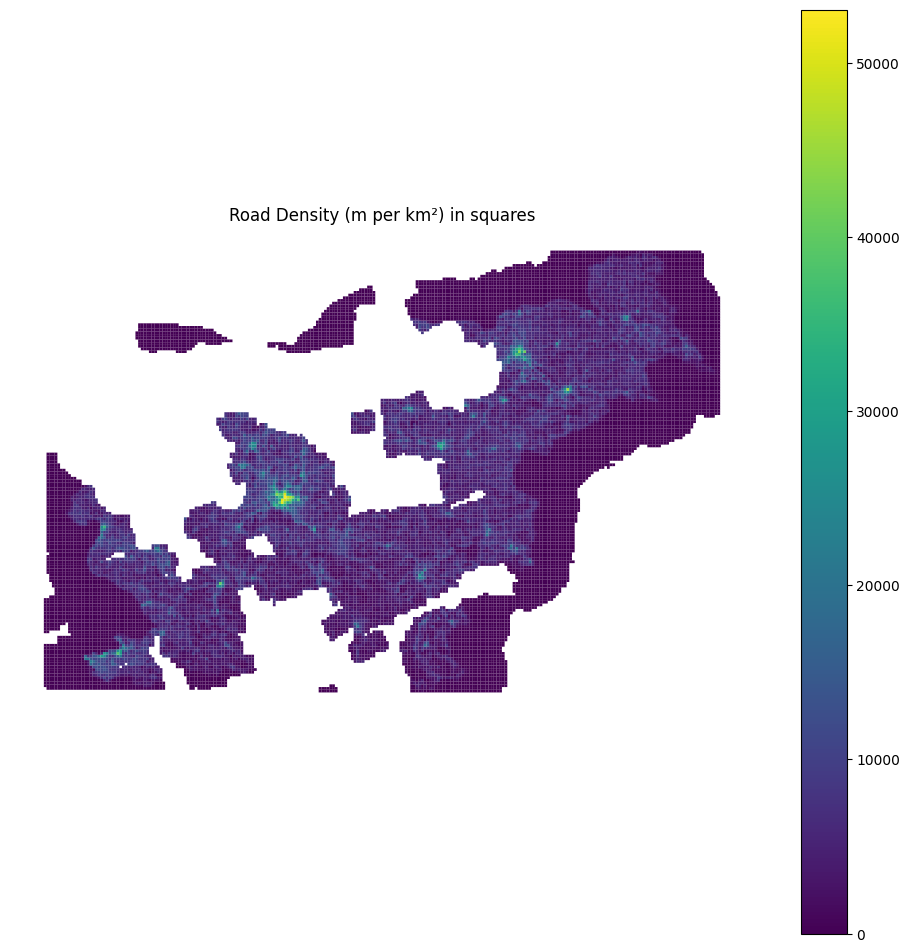

In [3]:
from shapely.geometry import Polygon

def polygon_from_row(row):
    sw_lon, sw_lat = row['sw_lon'], row['sw_lat']
    ne_lon, ne_lat = row['ne_lon'], row['ne_lat']
    return Polygon([
        (sw_lon, sw_lat),
        (sw_lon, ne_lat),
        (ne_lon, ne_lat),
        (ne_lon, sw_lat),
        (sw_lon, sw_lat)
    ])
    
df_pollution = pd.read_csv('pollution_SLO.csv')
df_pollution['geometry'] = df_pollution.apply(polygon_from_row, axis=1)

gdf_squares = gpd.GeoDataFrame(df_pollution, geometry='geometry', crs="EPSG:4326")
gdf_squares = gdf_squares.to_crs("EPSG:3794") 
gdf_squares['square_id'] = gdf_squares['grid_id']
print(gdf_squares.head())

roads = gpd.read_file("hotosm_svn_roads_lines_gpkg.gpkg")
roads = roads.to_crs("EPSG:3794") 
print(roads.shape)
print(roads.head())
print(roads.columns)

squares_for_overlay = gpd.GeoDataFrame(
    gdf_squares[['square_id', 'geometry']],
    geometry='geometry',
    crs=gdf_squares.crs
)

roads_in_squares = gpd.overlay(roads, gdf_squares, how='intersection')
roads_in_squares['road_length_m'] = roads_in_squares.geometry.length
road_length_per_square = roads_in_squares.groupby('square_id')['road_length_m'].sum().reset_index()
gdf_squares = gdf_squares.merge(road_length_per_square, on='square_id', how='left')
gdf_squares['road_length_m'] = gdf_squares['road_length_m'].fillna(0)
print(gdf_squares[['square_id', 'road_length_m']].head())

gdf_joined = df_pollution.merge(gdf_squares[['square_id', 'road_length_m']], left_on='grid_id', right_on='square_id', how='left')

gdf_squares.plot(column='road_length_m', cmap='viridis', figsize=(12, 12), legend=True)
plt.title("Road Density (m per km²) in squares")
plt.axis('off')
plt.show()

In [4]:
print(gdf_joined.columns)

Index(['grid_id', 'lon', 'lat', 'sw_lon', 'sw_lat', 'ne_lon', 'ne_lat', 'year',
       'no2_ppb', 'co_ppb', 'so2_ppb', 'o3_ppb', 'ch4_ppb', 'geometry',
       'square_id', 'road_length_m'],
      dtype='object')


In [5]:
# ======= POPULATION ================================================================================

population = gpd.read_file("kontur_population_SI_20220630.gpkg")
population = population.to_crs("EPSG:3794")  # match CRS

print("POPULATION IN SQUARES")
population_in_squares = gpd.overlay(population, gdf_squares, how='intersection')

print(population_in_squares.columns)
population_in_squares['population_sum'] = population_in_squares['population'] * population_in_squares.geometry.area
population_per_square = population_in_squares.groupby('square_id')['population_sum'].sum().reset_index()
gdf_squares = gdf_squares.merge(population_per_square, on='square_id', how='left')
gdf_squares['population_sum'] = gdf_squares['population_sum'].fillna(0)
print(gdf_squares[['square_id', 'population_sum']].head())
print(gdf_squares.columns)

gdf_joined = gdf_joined.merge(gdf_squares[['square_id', 'population_sum']], left_on='grid_id', right_on='square_id', how='left')

print(gdf_joined.columns)
print(gdf_joined.head())



POPULATION IN SQUARES
Index(['h3', 'population', 'grid_id', 'lon', 'lat', 'sw_lon', 'sw_lat',
       'ne_lon', 'ne_lat', 'year', 'no2_ppb', 'co_ppb', 'so2_ppb', 'o3_ppb',
       'ch4_ppb', 'square_id', 'road_length_m', 'geometry'],
      dtype='object')
  square_id  population_sum
0  475,5029             0.0
1  476,5029             0.0
2  477,5029             0.0
3  478,5029             0.0
4  479,5029             0.0
Index(['grid_id', 'lon', 'lat', 'sw_lon', 'sw_lat', 'ne_lon', 'ne_lat', 'year',
       'no2_ppb', 'co_ppb', 'so2_ppb', 'o3_ppb', 'ch4_ppb', 'geometry',
       'square_id', 'road_length_m', 'population_sum'],
      dtype='object')
Index(['grid_id', 'lon', 'lat', 'sw_lon', 'sw_lat', 'ne_lon', 'ne_lat', 'year',
       'no2_ppb', 'co_ppb', 'so2_ppb', 'o3_ppb', 'ch4_ppb', 'geometry',
       'square_id_x', 'road_length_m', 'square_id_y', 'population_sum'],
      dtype='object')
    grid_id        lon        lat     sw_lon     sw_lat     ne_lon     ne_lat  \
0  475,5029  14.6868

In [6]:
from geopandas import GeoDataFrame

# ======= INDUSTRY ==================================================================================
df_industry = pd.read_csv('industry_SLO.csv', encoding='latin1')
print(df_industry.shape)

def point_from_row(row):
    lat, lon = row['Lat'], row['Long']
    return Point([(lon, lat)])
    
df_industry['geometry'] = df_industry.apply(point_from_row, axis=1)
gdf_industry = gpd.GeoDataFrame(df_industry, geometry='geometry', crs="EPSG:4326")
gdf_joined = gpd.GeoDataFrame(gdf_joined, geometry='geometry', crs="EPSG:4326")
gdf_joined = gdf_joined.to_crs(gdf_industry.crs)

# Nearest factory to each pollution square
nearest = gpd.sjoin_nearest(
    gdf_joined, 
    gdf_industry[['geometry']], 
    how="left", 
    distance_col="distance_to_factory"
)


(1872, 54)


c:\Users\Katalea\.conda\envs\env_HACK\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [7]:
gdf_joined = nearest

<Figure size 800x600 with 0 Axes>

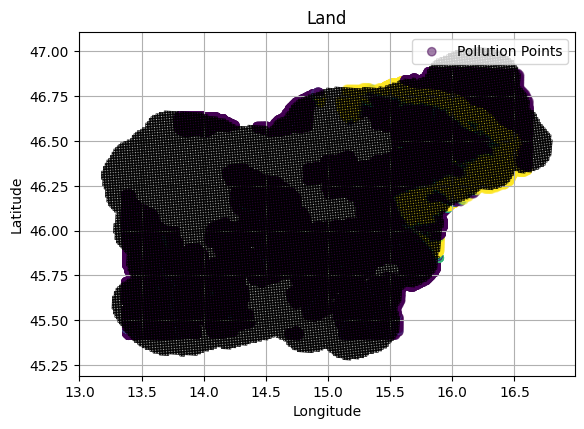

In [8]:
# LAND ==================================================================
land_path = os.path.join('land_data', 'lulc_results_2023.csv')
df_land = pd.read_csv(land_path, low_memory=False)	
df_land['lon'] = df_land['lon'].astype('float')
df_land['lat'] = df_land['lat'].astype('float')

# MERGE POLLUTION AND LAND DATA =========================================
df_land['geometry'] = df_land.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf_land = gpd.GeoDataFrame(df_land, geometry='geometry', crs="EPSG:4326")
gdf_joined = pd.merge(gdf_joined, df_land, on=['lat', 'lon', 'sw_lon','sw_lat','ne_lon','ne_lat'], how='inner')

plt.figure(figsize=(8, 6))
slovenia_shape.boundary.plot(color='black', linewidth=0.5)
plt.scatter(gdf_joined['lon'], gdf_joined['lat'], c=gdf_joined['class_1_percent'], alpha=0.5, label='Pollution Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Land')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# SAVE DATASET =========================================================

gdf_joined.to_csv('all_data.csv', index=False)
print(gdf_joined.head())
print(gdf_joined.columns)

  grid_id_x        lon        lat     sw_lon     sw_lat     ne_lon     ne_lat  \
0  475,5029  14.686858  45.418591  14.680442  45.414073  14.693273  45.423109   
1  475,5029  14.686858  45.418591  14.680442  45.414073  14.693273  45.423109   
2  476,5029  14.699639  45.418626  14.693224  45.414108  14.706053  45.423143   
3  476,5029  14.699639  45.418626  14.693224  45.414108  14.706053  45.423143   
4  477,5029  14.712420  45.418659  14.706006  45.414142  14.718833  45.423175   

     year   no2_ppb        co_ppb  ...  class_3_percent  class_4_percent  \
0  2024.0  0.000068  3.025123e+07  ...              0.0              0.0   
1  2024.0  0.000068  3.025123e+07  ...              0.0              0.0   
2  2024.0  0.000068  3.035399e+07  ...              0.0              0.0   
3  2024.0  0.000068  3.035399e+07  ...              0.0              0.0   
4  2024.0  0.000069  3.043667e+07  ...              0.0              0.0   

   class_5_percent class_6_percent class_7_percent  clas

In [10]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, KFold
import joblib

air_pollutants = ['no2_ppb', 'co_ppb', 'so2_ppb', 'o3_ppb', 'ch4_ppb']

print(gdf_joined.columns)
df = gdf_joined[['road_length_m', 'population_sum', 'distance_to_factory', 'class_1_percent', 'class_2_percent', 'class_3_percent', 'class_4_percent', 'class_5_percent', 'class_6_percent', 'class_7_percent', 'class_8_percent', 'class_9_percent', 'class_10_percent', 'class_11_percent'] + air_pollutants]

for pollutant in air_pollutants:
    print("POLLUTANT:", pollutant)
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[pollutant]), df[pollutant], test_size=0.2, random_state=42)
    
    to_remove = [a_pol for a_pol in air_pollutants if a_pol != pollutant]
    X_train = X_train.drop(columns=to_remove)
    X_test = X_test.drop(columns=to_remove)
    
    model = RandomForestRegressor(n_estimators=1000, random_state=42)
    
    """cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
    
    print("RMSE scores for each fold:", -scores)
    print("Average RMSE:", -scores.mean())
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_percentage_error')
    
    print("RMSE scores for each fold:", -scores)
    print("Average RMSE:", -scores.mean())"""
    
    model.fit(X_train, y_train)
    
    model_file_name = 'model_' + pollutant  +'.joblib'
    joblib.dump(model, model_file_name, compress=3)
    
    
    
    
    

Index(['grid_id_x', 'lon', 'lat', 'sw_lon', 'sw_lat', 'ne_lon', 'ne_lat',
       'year', 'no2_ppb', 'co_ppb', 'so2_ppb', 'o3_ppb', 'ch4_ppb',
       'geometry_x', 'square_id_x', 'road_length_m', 'square_id_y',
       'population_sum', 'index_right', 'distance_to_factory', 'grid_id_y',
       'LULC_mode', 'class_1_percent', 'class_2_percent', 'class_3_percent',
       'class_4_percent', 'class_5_percent', 'class_6_percent',
       'class_7_percent', 'class_8_percent', 'class_9_percent',
       'class_10_percent', 'class_11_percent', 'geometry_y'],
      dtype='object')
POLLUTANT: no2_ppb


KeyboardInterrupt: 